## This Notebook transfers a 288x1 Input (Values for Insulin) into a XxX Array

Import the required packages

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from utils.loading import load_table
import os

import pandas as pd
import plotly.express as px
import numpy as np

import tensorflow.keras.layers as tfl
import tensorflow as tf

import datetime
pd.set_option('display.max_rows', 1000)

## Parameters

In [15]:
CSV_INPUT = 'df_final_1.csv'
CONV_INPUT_LENGTH = 288
TRAIN_TEST_SPLIT = 0.8
GLUCOSE_OPTIMUM = 85

## Load data

In [3]:
df_raw = pd.read_csv(os.path.join('..', CSV_INPUT), )
df = df_raw.copy(deep=True)

In [5]:
df = df.sort_values('LocalDtTm')
train_length = int(TRAIN_TEST_SPLIT*df.shape[0])
df_train = df.iloc[:train_length,:]
df_test = df.iloc[train_length:,:]
assert df_test.shape[0] + df_train.shape[0] == df.shape[0]

X_train = df_train.drop(columns=['LocalDtTm', 'CGM'])
Y_train = df_train[['CGM']]

X_test = df_test.drop(columns=['LocalDtTm', 'CGM'])
Y_test = df_test[['CGM']]

## Model

In [21]:
# Custom loss function
class GlucoseLoss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()

    def call(self, y_true, y_pred, glucose_optimum=GLUCOSE_OPTIMUM):
        y_true = tf.cast(y_true, tf.float32) 
        return (y_pred-y_true)**2 * ((y_true-glucose_optimum)**2+6000)


In [120]:
# Custom metric
def hyper_metric(y_true, y_pred):
    
    y_true = tf.reshape(y_true, shape=(-1,))
    y_pred = tf.reshape(y_pred, shape=(-1,))
    preds_while_hyper = tf.boolean_mask(y_pred, mask=tf.greater(y_true, 100.0))
    return tf.reduce_mean(tf.cast(tf.greater(preds_while_hyper, 100.0), tf.float32))

# Custom metric
def hypo_metric(y_true, y_pred):
    
    y_true = tf.reshape(y_true, shape=(-1,))
    y_pred = tf.reshape(y_pred, shape=(-1,))
    preds_while_hyper = tf.boolean_mask(y_pred, mask=tf.less(y_true, 70.0))
    return tf.reduce_mean(tf.cast(tf.less(preds_while_hyper, 70.0), tf.float32))


In [69]:
def ConvLayers(input):
        
    assert input.shape[1] == CONV_INPUT_LENGTH
    # 1st CONV
    print(f'Conv1d {input.shape}')
    Conv1 = tfl.Conv1D(filters = 3, kernel_size = 5, strides = 1, padding = 'valid')(input)
    # Max Pool
    Pool1 = tfl.MaxPool1D(pool_size = 2, strides = 2, padding = 'valid')(Conv1)
    # 2nd CONV
    Conv2 = tfl.Conv1D(filters = 6, kernel_size = 5, strides = 1, padding = 'valid')(Pool1)
    # Max Pool
    Pool2 = tfl.MaxPool1D(pool_size = 6, strides = 4, padding = 'valid')(Conv2)
    # Now flatten the Matrix into a 1D vector (shape 1x204)
    Flatten = tfl.Flatten()(Pool2)

    #assert Flatten.shape[2] == 204
    return Flatten

In [142]:
def get_model():
    
    #Arguments: input_shape -- of shape 1x1x288, holds the insulin values
    
    # define the input with specified shape
    input = tf.keras.Input(shape =(CONV_INPUT_LENGTH*4,1), batch_size=None)
    batch_size = tf.shape(input)[0]
    
    diabetes_input = tf.slice(input, begin=[0,CONV_INPUT_LENGTH*0,0], size=[batch_size,CONV_INPUT_LENGTH,1], name='diabetes_input')
    meal_input = tf.slice(input, begin=[0,CONV_INPUT_LENGTH*1,0], size=[batch_size,CONV_INPUT_LENGTH,1])
    smbg_input = tf.slice(input, begin=[0,CONV_INPUT_LENGTH*2,0], size=[batch_size,CONV_INPUT_LENGTH,1])
    excercise_input = tf.slice(input, begin=[0,CONV_INPUT_LENGTH*3,0], size=[batch_size,CONV_INPUT_LENGTH,1])

    diabetes_conv = ConvLayers(diabetes_input)
    meal_conv = ConvLayers(meal_input)
    smbg_conv = ConvLayers(smbg_input)
    excercise_conv = ConvLayers(excercise_input)

    post_conv = tf.concat([diabetes_conv, meal_conv, smbg_conv, excercise_conv], axis=1, name='post_conv')
    
    assert post_conv.shape[1] == 204*4

    # Now fully connect layers
    FC1 = tfl.Dense(units = 512, activation = 'relu')(post_conv)
    # output a vector of shape 1x84
    FC2 = tfl.Dense(units = 256, activation = 'relu')(FC1)
    FC3 = tfl.Dense(units = 128, activation = 'relu')(FC2)
    FC4 = tfl.Dense(units = 64, activation = 'relu')(FC3)
    output = tfl.Dense(units = 1, activation = None)(FC4)

    # continuous function for blood glucose value
    # ...
    
    model = tf.keras.Model(inputs = input, outputs = output)
    return model

Now try the function:

In [143]:
conv_model = get_model()
conv_model.compile(optimizer='adam',
                  loss=GlucoseLoss(), 
                  metrics=['mse', hypo_metric, hyper_metric])
conv_model.summary()
    

Conv1d (None, 288, 1)
Conv1d (None, 288, 1)
Conv1d (None, 288, 1)
Conv1d (None, 288, 1)
Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 1152, 1)]    0           []                               
                                                                                                  
 tf.compat.v1.shape_35 (TFOpLam  (3,)                0           ['input_36[0][0]']               
 bda)                                                                                             
                                                                                                  
 tf.__operators__.getitem_35 (S  ()                  0           ['tf.compat.v1.shape_35[0][0]']  
 licingOpLambda)                                                                                  
   

In [144]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = conv_model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
136/136 [==============================] - 2s 8ms/step - loss: 110448256.0000 - mse: 6760.9453 - hypo_metric: nan - hyper_metric: nan - val_loss: 91366072.0000 - val_mse: 2977.6948 - val_hypo_metric: nan - val_hyper_metric: 0.9687
Epoch 2/10
136/136 [==============================] - 1s 10ms/step - loss: 65427388.0000 - mse: 4573.3828 - hypo_metric: nan - hyper_metric: nan - val_loss: 82974144.0000 - val_mse: 2667.1323 - val_hypo_metric: nan - val_hyper_metric: 0.9903
Epoch 3/10
136/136 [==============================] - 1s 10ms/step - loss: 51174056.0000 - mse: 3715.3999 - hypo_metric: nan - hyper_metric: nan - val_loss: 63172956.0000 - val_mse: 2420.8135 - val_hypo_metric: nan - val_hyper_metric: 1.0000
Epoch 4/10
136/136 [==============================] - 1s 10ms/step - loss: 40682712.0000 - mse: 3029.6460 - hypo_metric: nan - hyper_metric: nan - val_loss: 57122532.0000 - val_mse: 2654.2710 - val_hypo_metric: nan - val_hyper_metric: 1.0000
Epoch 5/10
136/136 [============

In [141]:
#px.scatter(Y_test, conv_model.predict(X_test))

#conv_model.predict(Y_).shape
conv_model.predict(X_train).shape
df_raw.shape

272/272 [==============================] - 1s 3ms/step


(10844, 1154)

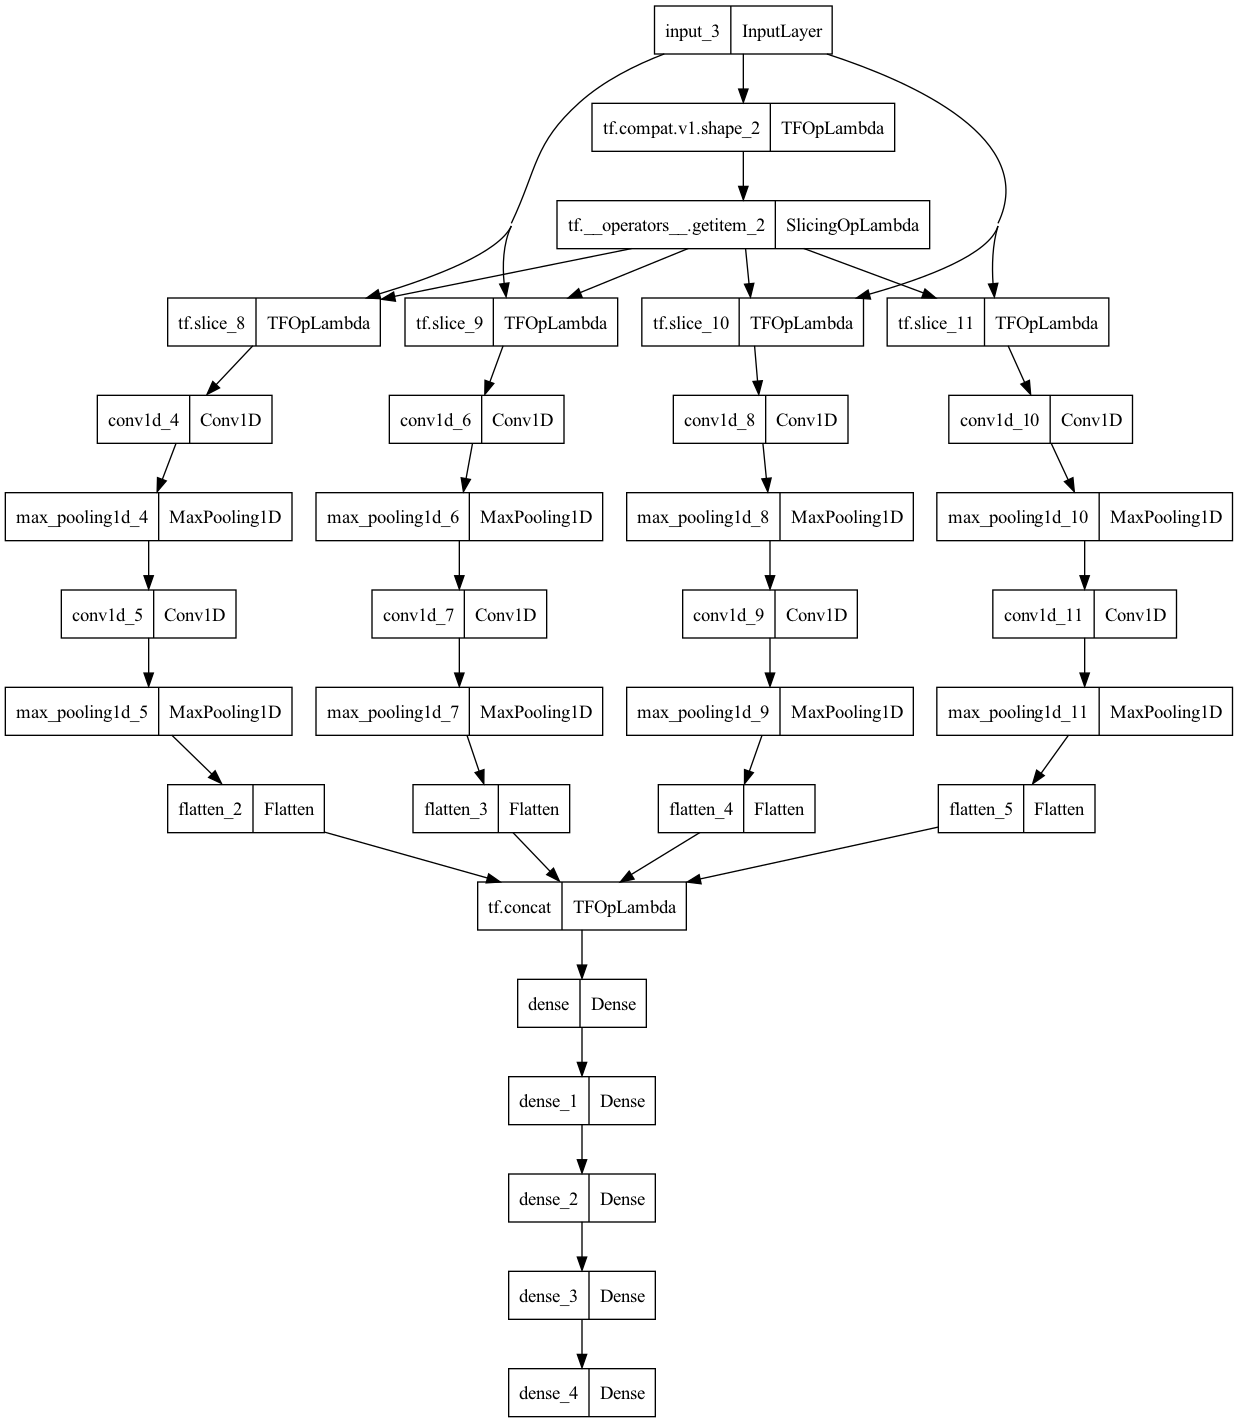

In [14]:
tf.keras.utils.plot_model(conv_model)